加載數據...
創建人工多類別目標...
多類別分布:
multi_target
1    1488
2    1472
0    1459
3    1455
Name: count, dtype: int64
應用 LDA 降維...
LDA 降維後形狀: (5874, 3)

進行SVM分類...
訓練集大小: 4111 樣本 (70.0%)
測試集大小: 1763 樣本 (30.0%)

SVM測試集準確率: 0.2575

分類報告:
              precision    recall  f1-score   support

           0       0.24      0.03      0.06       438
           1       0.30      0.13      0.19       446
           2       0.25      0.81      0.39       442
           3       0.24      0.05      0.08       437

    accuracy                           0.26      1763
   macro avg       0.26      0.26      0.18      1763
weighted avg       0.26      0.26      0.18      1763



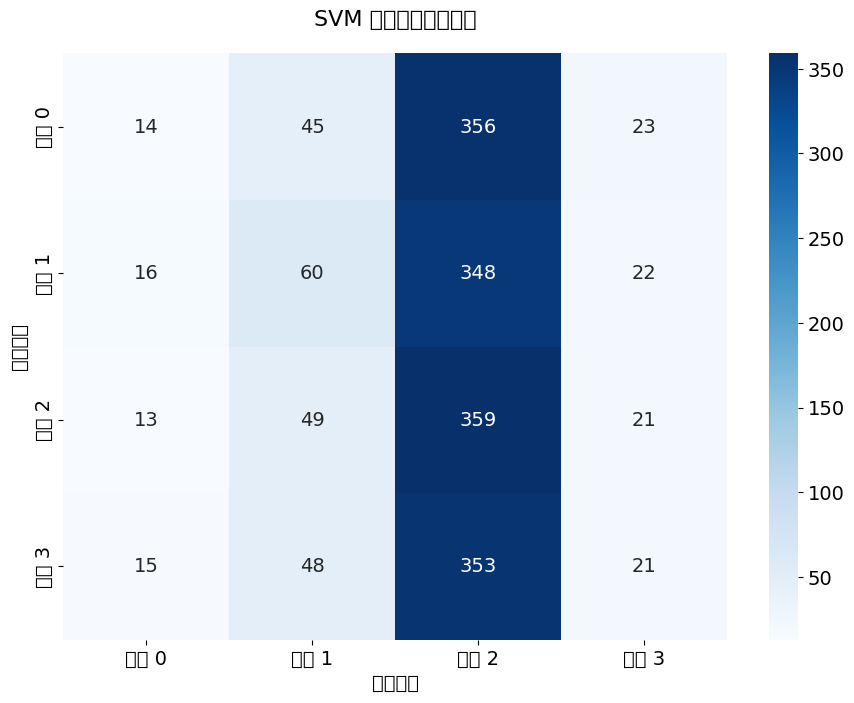

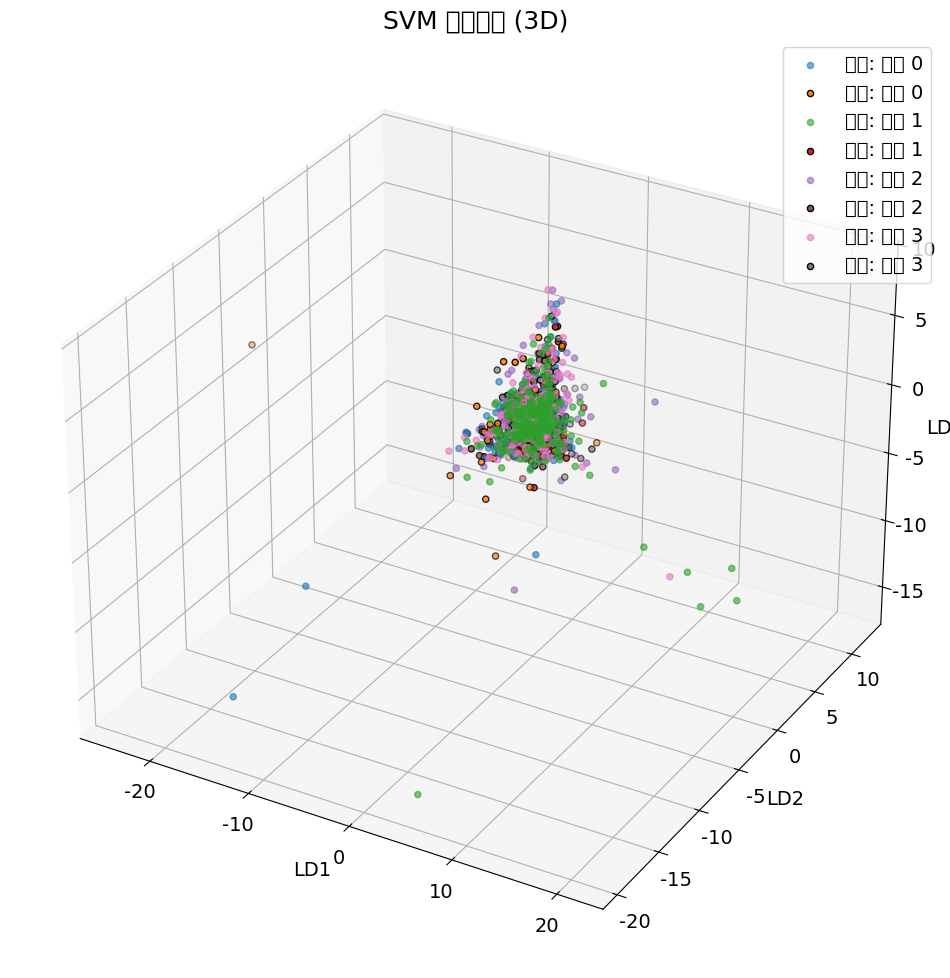

LDA降維 + SVM分類完成！


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# 設定中文字型支援
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 14

# 1. 加載數據
print("加載數據...")
url = 'https://raw.githubusercontent.com/zheng-hong-wu/Users-vs-bots-classification/refs/heads/main/bots_vs_users.csv'
df = pd.read_csv(url)

# 替換 'Unknown' 為 NaN 並填充缺失值
df.replace('Unknown', np.nan, inplace=True)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
df_clean = df[numeric_cols].copy()

# 填充缺失值（使用中位數提高穩定性）
for col in df_clean.columns:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# 創建人工多類別目標變數
print("創建人工多類別目標...")
np.random.seed(42)
df_clean['random_class1'] = np.random.randint(0, 2, size=len(df_clean))
df_clean['random_class2'] = np.random.randint(0, 2, size=len(df_clean))
df_clean['multi_target'] = df_clean['random_class1'] * 2 + df_clean['random_class2']

# 檢查多類別分布
print("多類別分布:")
print(df_clean['multi_target'].value_counts())

# 特徵準備
X = df_clean.drop(['multi_target', 'random_class1', 'random_class2'], axis=1)
y_multi = df_clean['multi_target']

# 添加微小擾動以打破完美共線性
X_jittered = X + np.random.normal(0, 0.0001, size=X.shape)

# 標準化特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_jittered)

# 使用 LDA 降維
print("應用 LDA 降維...")
n_classes = len(np.unique(y_multi))
max_components = min(X_scaled.shape[1], n_classes - 1)
n_components = max(1, min(3, max_components))

lda = LDA(n_components=n_components)
X_lda = lda.fit_transform(X_scaled, y_multi)
print(f"LDA 降維後形狀: {X_lda.shape}")

# ========= 分割資料並使用SVM分類 =========

# 按照70%訓練/30%測試的比例分割資料
print("\n進行SVM分類...")
X_train, X_test, y_train, y_test = train_test_split(
    X_lda, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)

print(f"訓練集大小: {X_train.shape[0]} 樣本 ({X_train.shape[0]/len(X_lda):.1%})")
print(f"測試集大小: {X_test.shape[0]} 樣本 ({X_test.shape[0]/len(X_lda):.1%})")

# 訓練 SVM 分類器
svm = SVC(kernel='rbf', C=1.0, gamma='auto', random_state=42)
svm.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = svm.predict(X_test)

# 評估分類性能
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nSVM測試集準確率: {test_accuracy:.4f}")

# 顯示測試集的分類報告
print("\n分類報告:")
print(classification_report(y_test, y_pred))

# 繪製混淆矩陣視覺化結果
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'類別 {i}' for i in sorted(np.unique(y_multi))],
            yticklabels=[f'類別 {i}' for i in sorted(np.unique(y_multi))])
plt.title('SVM 分類結果混淆矩陣', fontsize=16, pad=20)
plt.xlabel('預測類別', fontsize=14)
plt.ylabel('真實類別', fontsize=14)
plt.tight_layout(pad=3.0)
plt.show()

if X_lda.shape[1] == 2:
    # 2D視覺化決策邊界和分類結果
    plt.figure(figsize=(12, 10))

    # 創建網格以可視化決策邊界
    h = 0.02  # 網格步長
    x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
    y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

    # 預測網格點的類別
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 繪製決策邊界和分類點
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)

    colors = ['blue', 'red', 'green', 'purple']
    markers = ['o', '^', 's', 'D']

    for i in range(n_classes):
        plt.scatter(X_train[y_train == i][:, 0], X_train[y_train == i][:, 1],
                    color=colors[i], marker=markers[i], label=f'訓練: 類別 {i}', alpha=0.6)
        plt.scatter(X_test[y_test == i][:, 0], X_test[y_test == i][:, 1],
                    edgecolors='k', marker='x', s=120,
                    label=f'測試: 類別 {i}', alpha=0.9)

    plt.title('SVM 分類結果與決策邊界 (2D)', fontsize=18)
    plt.xlabel('LD1 (降維後特徵)', fontsize=14)
    plt.ylabel('LD2 (降維後特徵)', fontsize=14)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

elif X_lda.shape[1] == 3:
    # 如果是3D，則顯示3D視覺化結果（不含決策邊界）
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(n_classes):
        ax.scatter(X_train[y_train == i][:, 0], X_train[y_train == i][:, 1], X_train[y_train == i][:, 2],
                   label=f'訓練: 類別 {i}', alpha=0.6)
        ax.scatter(X_test[y_test == i][:, 0], X_test[y_test == i][:, 1], X_test[y_test == i][:, 2],
                   label=f'測試: 類別 {i}', edgecolors='k')

    ax.set_title('SVM 分類結果 (3D)', fontsize=18)
    ax.set_xlabel('LD1')
    ax.set_ylabel('LD2')
    ax.set_zlabel('LD3')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

print("LDA降維 + SVM分類完成！")
